Group 35 Project Proposal: Predicting Heart Disease

Introduction

The data below has been collected from 123 different patients and reports on specific aspects of their health with the purpose of determining the presence of heart disease in a patient. Similar data has been collected from hospitals in Budapest, Cleveland, and Switzerland, originally with 76 different variables. For the purposes of this project, the data used will only contain 14 variables, and is taken from the University hospital in Switzerland. The question to be answered is: How present is heart disease in a patient, with categorical values ranging from 0 (no heart disease present) to 4?


Preliminary Data Analysis

In [32]:
# Load package
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [33]:
# Read in the heart disease data, rename the column name and mutate all columns to be numeric
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data"
heart_disease <- read_csv(url, col_names = FALSE) %>%
                    mutate_if(is.character, as.numeric) %>%
                    rename(age = X1, sex = X2, chest_pain_type = X3, resting_BP = X4, cholesteral = X5, fasting_bs = X6, rest_ecg = X7,
                           max_hr = X8, ex_angina = X9, st_depression = X10, slope_st = X11, num_major_vessels = X12, thal = X13, diagnosis = X14)


Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_double(),
  X6 = col_character(),
  X7 = col_character(),
  X8 = col_character(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)

Warning message:
“Problem with `mutate()` input `X4`.
ℹ NAs introduced by coercion
ℹ Input `X4` is `.Primitive("as.double")(X4)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `X6`.
ℹ NAs introduced by coercion
ℹ Input `X6` is `.Primitive("as.double")(X6)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `X7`.
ℹ NAs introduced by coercion
ℹ Input `X7` is `.Primitive("as.double")(X7)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coerci

In [34]:
# Mutate the diagnosis column to be a factor
heart_disease <- mutate(heart_disease, diagnosis = as.factor(diagnosis))

# Select useful columns , remove any rows that contain NA
heart_disease <- select(heart_disease, age, sex, chest_pain_type, resting_BP, rest_ecg, max_hr, ex_angina, st_depression, slope_st, thal, diagnosis) %>%
                        na.omit()
heart_disease

age,sex,chest_pain_type,resting_BP,rest_ecg,max_hr,ex_angina,st_depression,slope_st,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
36,1,4,110,0,125,1,1,2,6,1
38,0,4,110,0,156,0,0,2,3,1
38,1,3,115,0,128,1,0,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
70,1,4,115,1,92,1,0,2,7,1
70,1,4,140,0,157,1,2,2,7,3
73,0,3,160,1,121,0,0,1,3,1


In [35]:
# Set the seed
set.seed(999) 

# Split the data into a training and test set

heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = diagnosis)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)


In [36]:
# Group by diagnosis and find average age, resting blood pressure and maximum heart rate achieved, 
# the number of observations, and percentage in each group

heart_disease_train_table <- heart_disease_train %>%
                                select(age,resting_BP, max_hr, diagnosis)%>%
                                group_by(diagnosis)%>%
                                summarize(avg_age = round(mean(age), digits = 1),
                                          avg_resting_BP = round(mean(resting_BP)),
                                          avg_max_hr = round(mean(max_hr)),
                                          num_obs = n(),
                                          percentage = round(n()/ nrow(heart_disease_data)*100,digits = 1))

`summarise()` ungrouping output (override with `.groups` argument)



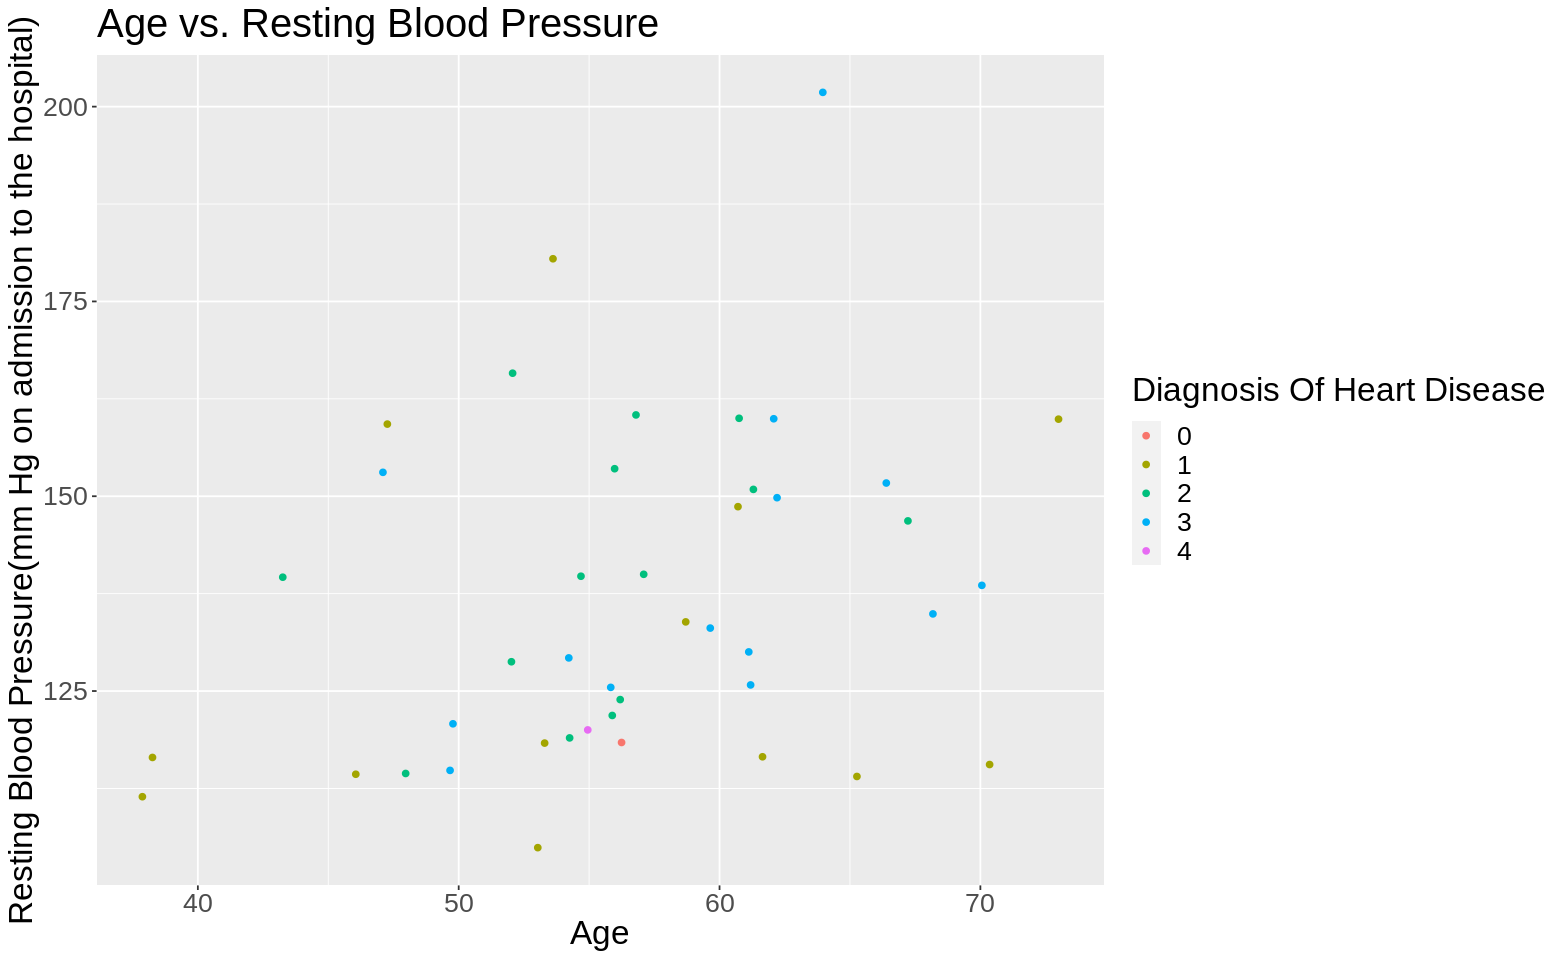

In [37]:
# Plot for age vs. resting blood pressure

options(repr.plot.width = 13, repr.plot.height = 8)

resting_BP_plot <- heart_disease_train %>%
                    ggplot(aes(x = age, y = resting_BP, color = diagnosis))+
                    geom_point(position = "jitter")+
                    labs(x = "Age", y = "Resting Blood Pressure(mm Hg on admission to the hospital)", colour = "Diagnosis Of Heart Disease")+
                    ggtitle("Age vs. Resting Blood Pressure")+
                    theme(text = element_text(size = 20))+
                    scale_y_continuous(labels = scales::comma)
resting_BP_plot

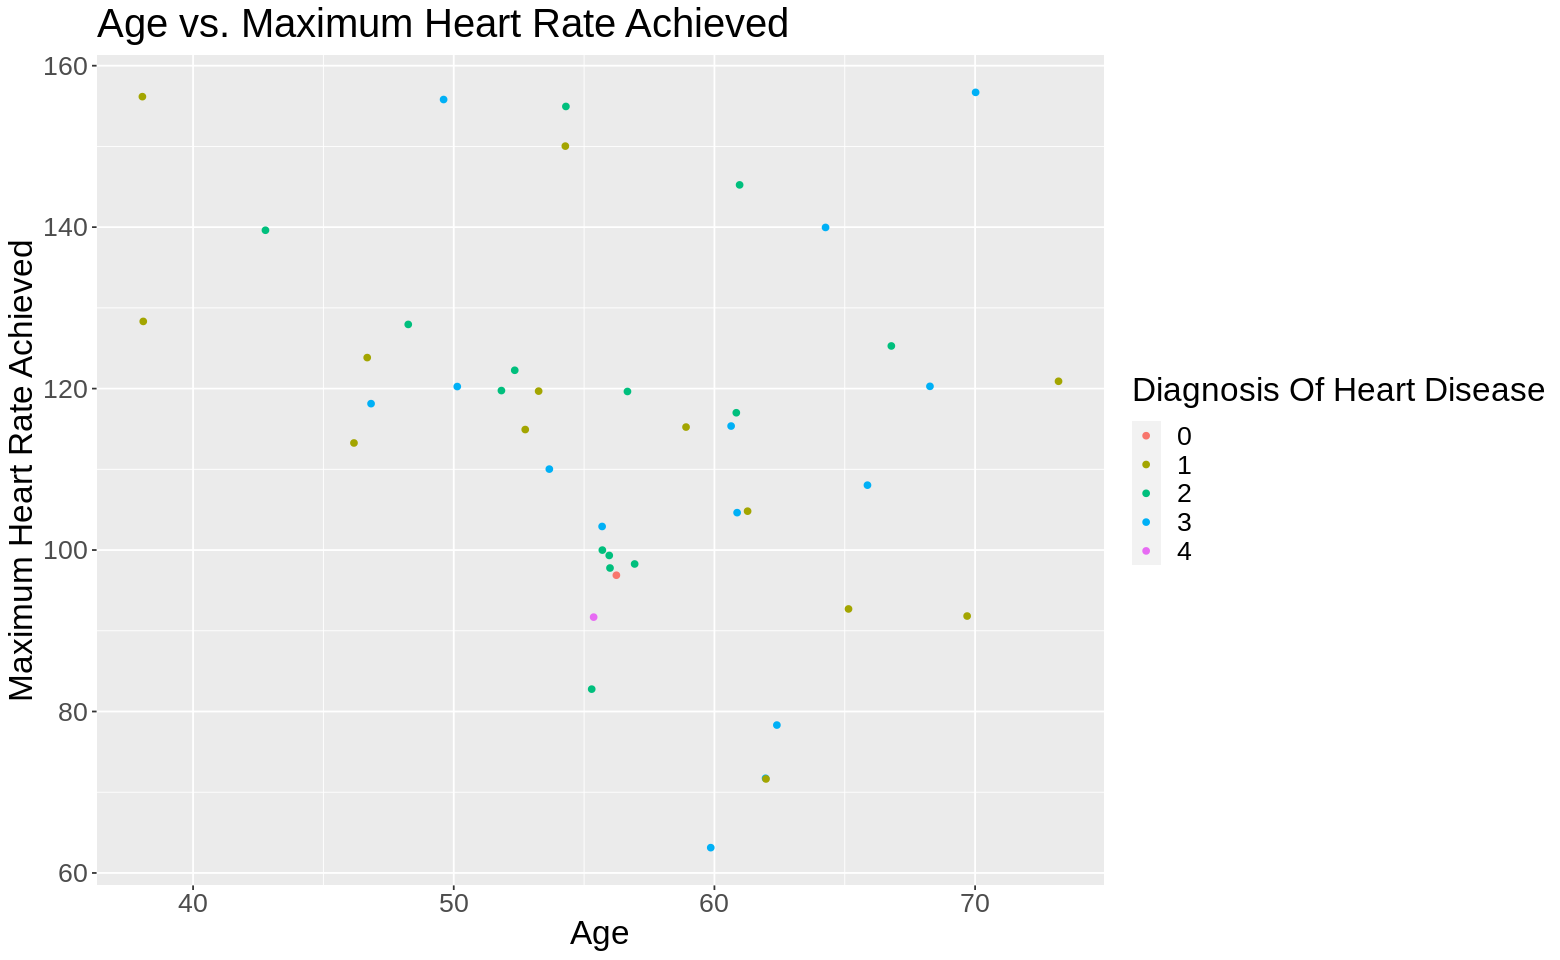

In [38]:
# Plot for age vs. maximum heart rate achieved

options(repr.plot.width = 13, repr.plot.height = 8)

max_hr_plot <- heart_disease_train %>%
                    ggplot(aes(x = age, y = max_hr, color = diagnosis))+
                    geom_point(position = "jitter")+
                    labs(x = "Age", y = "Maximum Heart Rate Achieved", colour = "Diagnosis Of Heart Disease")+
                    ggtitle("Age vs. Maximum Heart Rate Achieved")+
                    theme(text = element_text(size = 20))+
                    scale_y_continuous(labels = scales::comma)
max_hr_plot

Methods

We will use KNN classification to predict the diagnosis. We will create a classifier, tune the classifier and visualize the results.

We will use the variables: 
age = (yrs)
sex = (1 = male, 0 = female)
chest_pain_type = (1-4)
resting_BP = resting blood pressure (mm Hg on admission to the hospital)
rest_ecg = resting electrocardiographic results
0: normal
1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
2: showing probable or definite left ventricular hypertrophy by Estes' criteria
max_hr = maximum heart rate achieved
ex_angina = exercise induced angina (1 = yes; 0 = no)
st_depression = ST depression induced by exercise relative to rest
slope_st = the slope of the peak exercise ST segment (1: upsloping, 2: flat, 3: downsloping)
thal = Thalassemia (3: normal; 6: fixed defect; 7: reversible defect)
diagnosis = diagnosis of heart disease (Value 0: < 50% diameter narrowing, Value 1: > 50% diameter narrowing)

We will make a plot of predicted and true diagnosis values with a best fit line through the true values, of "a variable" vs "diagnosis"



Expected outcomes and Significance

First, we expect to find the best KNN classifier which has the highest accuracy that predicts diagnosis.
Second, we expect to find the best fitted line for the age and one (or several) specific aspect(s) of health. 

Assuming that a positive relationship exists between age and cholesterol level, for instance, there should be a best fitted line which has the least residues. And we can conclude that as people grow older, the possibility of obtaining a higher cholesterol becomes greater. If this conclusion holds true for age versus all other variables, we can say that people should pay more attention to heart disease as they grow older. 
This may lead to a few future questions. If there exists one or some variables that doesn’t have a linear relationship with sex, will the regression method we leaarnt still be working? Hence, what conclusion should we draw from our data? What’s more, since in our data, there’s also a column called “sex”, so what will happen if we take “sex” into consideration? Will our primary conclusion still hold true? If it does, how do the slopes of the best fitted line differ between  males and females? If it doesn’t, what will our further conclusion be like? 
